## Show System Specifications

In [245]:
from tensorflow.python.client import device_lib

print("Show System RAM Memory:\n\n")
!cat /proc/meminfo | egrep "MemTotal*"

print("\n\nShow Devices:\n\n"+str(device_lib.list_local_devices()))

Show System RAM Memory:


MemTotal:        7843732 kB


Show Devices:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7134038409300763935
]


## Download Dependencies

In [246]:
#!pip install opencv-python
#!pip install progressbar2
#!pip install moviepy

import sys, os
import numpy as np
import pandas as pd

import cv2
import progressbar
import time

from mark_detector import MarkDetector
from pose_estimator import PoseEstimator
from moviepy.editor import *

## Define input/output

In [311]:
import_path = '../videos'
export_path = '../videos/result/'

program_name = 'resnet_face_alignment'
input_filename = 'Expression-Brow-Down'
#input_filename = 'Example-Person01'

video_input = '{:s}/{:s}.mp4'.format(import_path,input_filename)
video_output = '{:s}/{:s}_{:s}.mp4'.format(export_path,input_filename,program_name)

if not os.path.exists(export_path):
    os.makedirs(export_path)

## Input video preview

In [312]:

clip = VideoFileClip(video_input)
clip.ipython_display(width=200)

chunk:  10%|█         | 50/498 [00:00<00:00, 491.20it/s, now=None]

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in %s


t:   2%|▏         | 13/676 [00:00<00:05, 126.28it/s, now=None]     

MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


## Create instances

In [313]:
vidin = cv2.VideoCapture(video_input)
ret,frame = vidin.read()
fps = vidin.get(cv2.CAP_PROP_FPS)
frames = vidin.get(cv2.CAP_PROP_FRAME_COUNT)

print(' Video FPS rate is {}'.format(fps))
print(' {} total frames'.format(frames))
print(' Frame size : {}'.format(frame.shape))
height, width = frame.shape[:2]

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
vidout = cv2.VideoWriter(video_output,fourcc, fps, (width,height))

# To setup the Landmark detector.
mark_detector = MarkDetector()

# To setup the Pose estimator.
pose_estimator = PoseEstimator(img_size=(height, width))

 Video FPS rate is 29.955
 676.0 total frames
 Frame size : (720, 406, 3)


## Head pose estimation loop

In [314]:
poses = []
CNN_INPUT_SIZE = 128
with progressbar.ProgressBar(max_value=frames) as bar:
    n = 0
    while(vidin.isOpened()):
        ret, frame = vidin.read()
        if frame is None:
            break
        rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Crop it if frame is larger than expected.
        # frame = frame[0:480, 300:940]

        # Pose estimation by 3 steps:
        # 1. detect face;
        # 2. detect landmarks;
        # 3. estimate pose
        
        # Start timer
        start_time = time.time()

        facebox = mark_detector.extract_cnn_facebox(rgb_image)
        
        # Calculate elapsed time
        exe_time_1 = time.time() - start_time
        
        # Get face from box queue.
        if facebox is not None:
            mark_detector.draw_crosshairs(frame,facebox,(0,255,255))
            #mark_detector.draw_box(frame,facebox)
            
            # Detect landmarks from image of 128x128.
            face_img = rgb_image[facebox[1]:facebox[3],facebox[0]:facebox[2]]
            face_img = cv2.resize(face_img, (CNN_INPUT_SIZE, CNN_INPUT_SIZE))
            
            # Start timer
            start_time = time.time()
            
            marks = mark_detector.detect_marks(face_img)
            
            # Calculate elapsed time
            exe_time_2 = time.time() - start_time

            # Convert the marks locations from local CNN to global image.
            marks *= (facebox[2] - facebox[0])
            marks[:, 0] += facebox[0]
            marks[:, 1] += facebox[1]
            # Show raw marks.
            mark_detector.draw_marks(frame, marks, color=(0, 255, 0))

            # Try pose estimation with 68 points.
            pose = pose_estimator.solve_pose_by_68_points(marks)
            poses.append([np.transpose(pose[0].copy())[0],np.transpose(pose[1].copy())[0]])

            # Draw pose annotaion on frame.
            #pose_estimator.draw_annotation_box(frame, pose[0], pose[1], color=(255, 128, 128))

        else:
            poses.append([np.zeros((1,3)),np.zeros((1,3))])
            
        # Calculate elapsed time
        elapsed_time = time.time() - start_time

        cv2.putText(frame, "Video FPS rate is {}".format(fps),                        (10,20),  cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,125,0), 1, cv2.LINE_AA);
        cv2.putText(frame, "{:d} total frames".format(int(frames)),                   (10,40),  cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,125,0), 1, cv2.LINE_AA);
        cv2.putText(frame, "Frame size : {}".format(frame.shape),                     (10,60),  cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,125,0), 1, cv2.LINE_AA);
        cv2.putText(frame, "Execution1 : {:04d} [ms]".format(int(1000*exe_time_1)),   (10,80),  cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,125,0), 1, cv2.LINE_AA);
        cv2.putText(frame, "Execution2 : {:04d} [ms]".format(int(1000*exe_time_2)),   (10,100), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,125,0), 1, cv2.LINE_AA);
        cv2.putText(frame, "Nod   : {:01d}".format(0),                                (10,120), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,125,0), 1, cv2.LINE_AA);
        cv2.putText(frame, "Shake : {:01d}".format(0),                                (10,140), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,125,0), 1, cv2.LINE_AA);

        # Write the frame
        vidout.write(frame)
        n = n + 1
        bar.update(n)

100% (1000 of 1000) |####################| Elapsed Time: 0:01:10 Time:  0:01:10


## Release video objects

In [306]:
# Release everything if job is finished
vidin.release()
vidout.release()

In [307]:
# Export poses to csv file
df = pd.DataFrame(poses,columns=['rotation_vector','translation_vector'])
df.to_csv('{:s}/{:s}_{:s}.csv'.format(export_path,input_filename,program_name), sep=',',index=False)

IndexError: index 1 is out of bounds for axis 0 with size 1

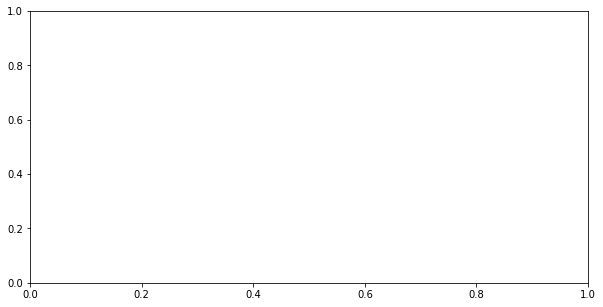

In [308]:
# Plot the scores
import matplotlib.pyplot as plt

fig = plt.figure(num=None,figsize=(10, 5))
ax = fig.add_subplot(111)
steps = np.arange(len(poses))
rotation_vector = np.zeros((len(poses),3))
translation_vector = np.zeros((len(poses),3))
for n in range(len(poses)):
    rotation_vector[n][:] = [df.rotation_vector[n][0],df.rotation_vector[n][1],df.rotation_vector[n][2]]
    translation_vector[n][:] = [df.translation_vector[n][0],df.translation_vector[n][1],df.translation_vector[n][2]]

plt.subplot(2, 1, 1)
plt.plot(rotation_vector[:])
plt.title('Rotation vector')
plt.legend(['x', 'y','z'])

plt.subplot(2, 1, 2)
plt.plot(translation_vector[:])
plt.title('Translation vector')
plt.legend(['x', 'y','z'])

#plt.ylabel('Score')
#plt.xlabel('Episode')

plt.tight_layout()
plt.show()

#fig.savefig('scores/{:s}.png'.format(filename)) # save the figure to file

## Check output

In [309]:
clip = VideoFileClip(video_output)
clip.ipython_display(width=width)

t:  15%|█▍        | 27/185 [00:00<00:00, 266.91it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


ValueError: The duration of video __temp__.mp4 (185.0) exceeds the 'maxduration' attribute. You can increase 'maxduration', by passing 'maxduration' parameterto ipython_display function.But note that embedding large videos may take all the memory away !